In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy.stats

import torch

from cca import ComplexityComponentsAnalysis
from cca.cov_util import (calc_pi_from_cross_cov_mats, calc_cov_from_cross_cov_mats,
                          project_cross_cov_mats)
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as LR

In [2]:
T_pi = 5

In [3]:
fname = '/storage/cnmd/insects/bees8-full.h5'
fname = '/storage/cnmd/water/waves3.h5'

In [4]:
with h5py.File(fname) as f:
    imgs = f['imgs'][()].astype(float)
mean = imgs.mean(axis=0)

In [24]:
imgs_small = resize(imgs, (imgs.shape[0]//3, 16, 16), anti_aliasing=True)
X = imgs_small.reshape(imgs_small.shape[0], -1).astype(float)
n_samples = X.shape[0]
split_idx = int(n_samples * .9)
train = X[:split_idx - T_pi]
test = X[split_idx + T_pi:]
train_mean = train.mean(axis=0, keepdims=True)
train -= train_mean
test -= train_mean

/home/jesse/anaconda3/envs/dca/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [25]:
def eval(trainp, trainf, testp, testf, lags):
    results = np.zeros((lags.size, 2))
    for ii, lag in enumerate(lags):
        model = LR(fit_intercept=False).fit(trainp[:-lag], trainf[lag:])
        results[ii] = model.score(trainp[:-lag], trainf[lag:]), model.score(testp[:-lag], testf[lag:])
    return results

In [30]:
dims = np.arange(2, 20, 2)
lags = np.array([5, 10, 20])

results = np.zeros((2, dims.size, lags.size, 2))

dca_model = ComplexityComponentsAnalysis(T=T_pi)
dca_model.estimate_cross_covariance(train) #, regularization='kron')

for ii, d in enumerate(dims):
    print(d)
    pca_model = PCA(d).fit(train)
    trainp = pca_model.transform(train)
    testp = pca_model.transform(test)
    results[0, ii] = eval(trainp, train, testp, test, lags)
    dca_model.fit_projection(d=d)
    trainp = dca_model.transform(train)
    testp = dca_model.transform(test)
    results[1, ii] = eval(trainp, train, testp, test, lags)
    print(results[:, ii])

2
[[[0.49401256 0.45155266]
  [0.31550441 0.24666142]
  [0.12563969 0.02364733]]

 [[0.48397745 0.44087915]
  [0.30623079 0.23850028]
  [0.12307867 0.02224606]]]
4
[[[0.52084147 0.4851397 ]
  [0.33042914 0.26538436]
  [0.13120399 0.03346759]]

 [[0.51453643 0.47360417]
  [0.32115196 0.24725704]
  [0.12691912 0.0219473 ]]]
6
[[[0.53412478 0.50449927]
  [0.33741963 0.2783836 ]
  [0.13791138 0.05496901]]

 [[0.53074496 0.49999157]
  [0.33305096 0.27466676]
  [0.13411243 0.05011257]]]
8
[[[0.54022268 0.50748382]
  [0.34285613 0.27648357]
  [0.14303046 0.05299129]]

 [[0.53813401 0.50669008]
  [0.3401302  0.27702967]
  [0.14093586 0.05416707]]]
10
[[[0.54234262 0.5085892 ]
  [0.34405982 0.27435883]
  [0.144549   0.05050576]]

 [[0.54026975 0.50960975]
  [0.3409377  0.27795428]
  [0.14171334 0.05568731]]]
12
[[[0.54358416 0.50978486]
  [0.34454493 0.27388834]
  [0.1448342  0.05037294]]

 [[0.54316548 0.51063133]
  [0.34364017 0.2759695 ]
  [0.1446635  0.05256034]]]
14
[[[0.54555583 0.5112109

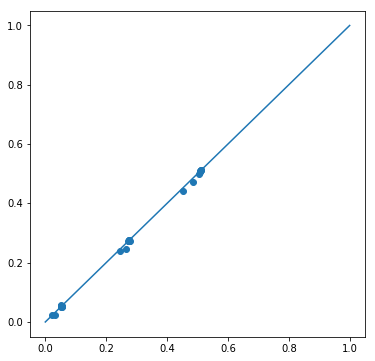

In [31]:
f, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(results[0, :, :, 1].ravel(), results[1, :, :, 1].ravel())
ax.plot([0, 1.], [0, 1])

(array([ 1.,  1.,  0.,  1.,  1.,  2.,  8., 19.,  4.,  2.]),
 array([-0.01067433, -0.00939836, -0.0081224 , -0.00684643, -0.00557046,
        -0.0042945 , -0.00301853, -0.00174256, -0.0004666 ,  0.00080937,
         0.00208534]),
 <a list of 10 Patch objects>)

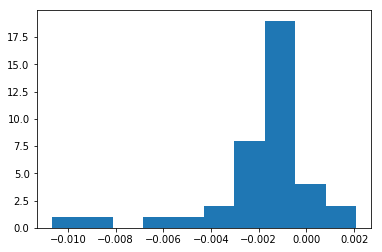

In [28]:
plt.hist((results[1, :, :, 1] - results[0, :, :, 1]).ravel())